# StochSS-Compute Tutorial
This self-contained tutorial will show you how to use StochSS-Compute with the Python Dask API to run a simulation. Since it is self-contained, you should shut down any other StochSS-Compute servers or Dask clusters you may have running before beginning.  
If you have ever used GillesPy2 to run simulations locally, you almost already know how to run remote simulations, as the syntax is nearly the same. Running a simulation remotely with GillesPy2 requires 3 components: a `Model()` (your data), a `Solver()` (SSA, TauHybrid, ODE, etc.), and a running instance of a `ComputeServer()`. If you do not wish to explicitly state the solver, one will be automatically chosen.

#### 1. First, import the necessary dependencies.

In [1]:
# Tutorial-specific dependencies
import sys, os            # used to set $PATH
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

import subprocess         # used to run the api server in the background

# GillesPy2

import gillespy2
import numpy

# StochSS-Compute

from stochss_compute import RemoteSimulation

# Dask

from distributed import Client

#### 2. Instantiate a dask.distributed cluster.  

This command will start up a single-machine dask.distributed cluster on `localhost` with default settings. By default, the number of workers corresponds to the number of cores on your machine. If you are deploying by the command line or Docker, skip this step.

For in-depth customization, refer to:  

https://docs.dask.org/en/latest/how-to/deploy-dask/single-distributed.html  

For information about deployment via command line, see:  

https://docs.dask.org/en/latest/how-to/deploy-dask/cli.html  

For other and more advanced deployments:  

https://docs.dask.org/en/latest/how-to/deploy-dask/python-advanced.html  
https://docs.dask.org/en/latest/how-to/deploy-dask-clusters.html  
https://github.com/dask/dask-tutorial

In [ ]:
client = Client()
# Click the link that appears to see the dashboard. 
client

Pass the correct address and port of the dask scheduler to the `ComputeServer`. In this case, the address is `"localhost"`, the default. Here is one way to find the port:

In [ ]:
dask_scheduler_port = client.scheduler.addr.split(":")[2]
dask_scheduler_port

#### 3. Start up the `ComputeServer`

Now we can start the API server in the background. Full output will appear in the file `stdout`. If you prefer, you can instead run this in a terminal window.  
  
Note:
- `stochss-compute` is used to connect to an already running dask cluster.
- `stochss-compute-cluster` starts up a dask cluster for you.

In [ ]:
cmd = ["python", "-m", "stochss_compute.launch", "--dask-scheduler-port", dask_scheduler_port]
api_server = subprocess.Popen(cmd, stdout=open('stdout', 'w'), stderr=open('stderr', 'w'))
api_server

#### 4. Creating a GillesPy2 Model  
  
A GillesPy2 model must include species, rates, and reactions.

In [2]:
def create_michaelis_menten(parameter_values=None):
    # Intialize the Model with a name of your choosing.
    model = gillespy2.Model(name="Michaelis_Menten")

    """
    Variables (GillesPy2.Species) can be anything that participates in or is produced by a reaction channel.

    - name: A user defined name for the species.
    - initial_value: A value/population count of species at start of simulation.
    """
    A = gillespy2.Species(name="A", initial_value=301)
    B = gillespy2.Species(name="B", initial_value=120)
    C = gillespy2.Species(name="C", initial_value=0)
    D = gillespy2.Species(name="D", initial_value=0)

    # Add the Variables to the Model.
    model.add_species([A, B, C, D])

    """
    Parameters are constant values relevant to the system, such as reaction kinetic rates.

    - name: A user defined name for reference.
    - expression: Some constant value.
    """
    rate1 = gillespy2.Parameter(name="rate1", expression=0.0017)
    rate2 = gillespy2.Parameter(name="rate2", expression=0.5)
    rate3 = gillespy2.Parameter(name="rate3", expression=0.1)

    # Add the Parameters to the Model.
    model.add_parameter([rate1, rate2, rate3])

    """
    Reactions are the reaction channels which cause the system to change over time.

    - name: A user defined name for the reaction.
    - reactants: A dictionary with participant reactants as keys, and consumed per reaction as value.
    - products: A dictionary with reaction products as keys, and number formed per reaction as value.
    - rate: A parameter rate constant to be applied to the propensity of this reaction firing.
    - propensity_function: Can be used instead of rate in order to declare a custom propensity function in string format.
    """
    r1 = gillespy2.Reaction(
            name="r1",
            reactants={'A': 1, 'B': 1}, 
            products={'C': 1},
            rate='rate1'
        )

    r2 = gillespy2.Reaction(
            name="r2",
            reactants={'C': 1}, 
            products={'A': 1, 'B': 1},
            rate='rate2'
        )

    r3 = gillespy2.Reaction(
            name="r3",
            reactants={'C': 1}, 
            products={'B': 1, 'D': 1},
            rate='rate3'
        )

    # Add the Reactions to the Model.
    model.add_reaction([r1, r2, r3])

    # Define the timespan of the model.
    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=100)
    
    # Set the timespan of the Model.
    model.timespan(tspan)
    return model

### Running Simulations and Plotting

First, instantiate a `Model()`. Next, instantiate a `ComputeServer()` that points to your running instance of StochSS-Compute. After you call `run()`, which returns your future `RemoteResults`, you will have to wait for the simulation to finish. Calling `wait()`, `status()`, `resolve()`, or `cancel()` allows you to interact with your results. Call `resolve()` to wait for the simulation to finish and fetch the results. Continue reading for more details on the various parameters that you may set.

In [3]:
myModel = create_michaelis_menten()

In [4]:
simulation = RemoteSimulation(myModel, host='localhost', solver=gillespy2.NumPySSASolver)

In [6]:
results = simulation.run(number_of_trajectories=100)

[SimulationRunRequest] http://localhost:29681/api/v2/simulation/gillespy2/run


Results ready. Fetching.......


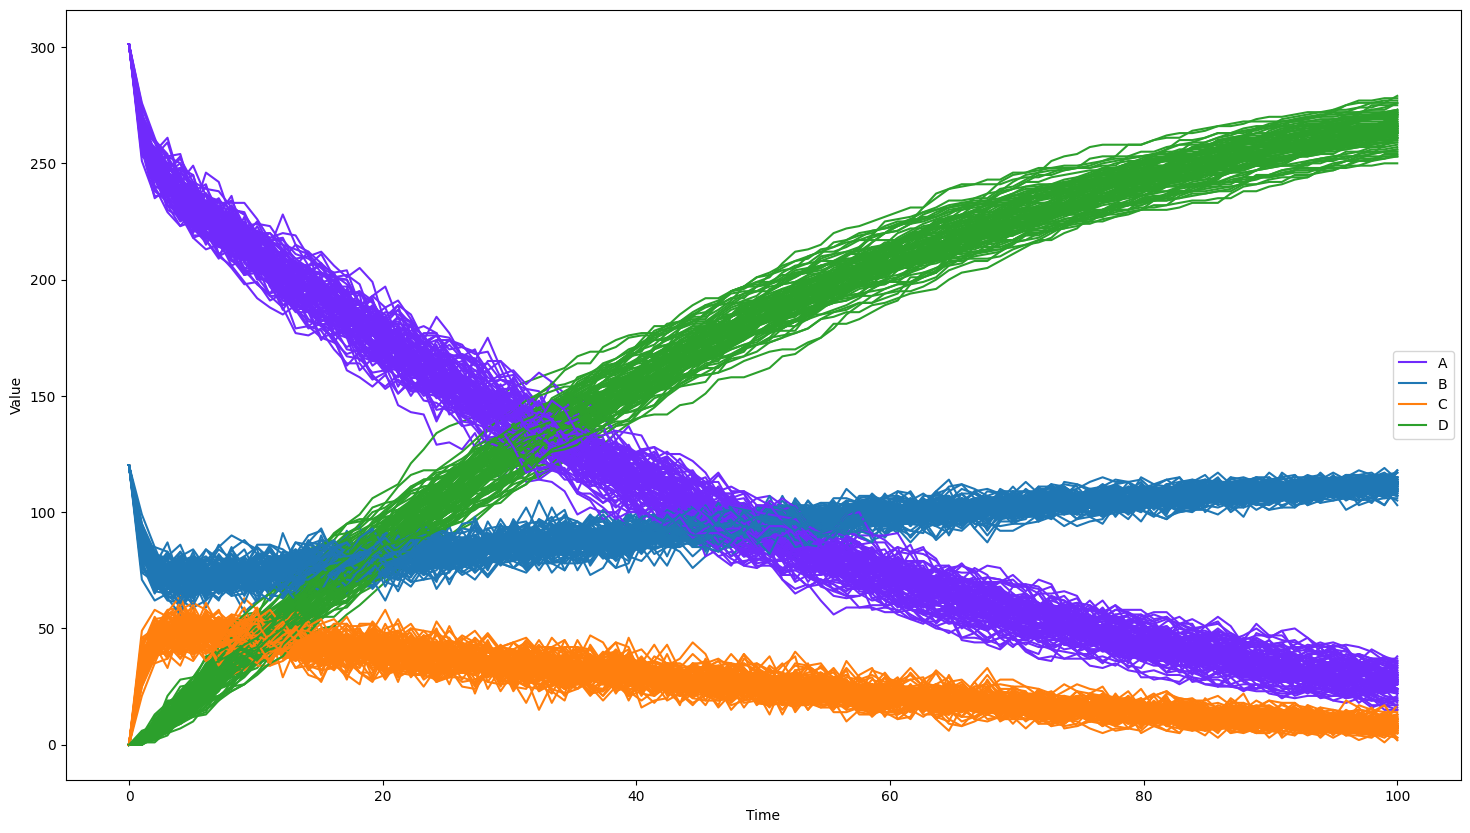

In [7]:
results.plot()

#### 6. Shut-down

Sends a `SIGTERM` to the `ComputeServer`

In [ ]:
api_server.terminate()

Shuts down the dask cluster

In [ ]:
client.shutdown()

#### 7. Options
#### Model.run() keyword arguments
While the model.run() function can be called without any given arguments, GillesPy2 provides several options for customizing your simulations. The following keyword arguments can be used in the model.run() function to customize your simulations:  

**algorithm=None**  
    [str]: Manually choose an algorithm from one of the following GillesPy2 solvers:  
    "ODE"  
    "Tau-Hybrid"    
    "Tau-Leaping"    
    "SSA"    
    
**number_of_trajectories=1**  
    [int]: Number of times to run the current simulation.  
    
**seed=None**  
    [int]: Define a custom seed for random number generation.

**show_labels=True**  
    [bool]: When set to true (default) returns results in a dictonary with time and species as dictionary keys, and relevant trajectory vectors as value pair.  When set to False, results will be returned as a numpy array with dimensions [timestep][species_index].  Either way, the the results of each trajectory are stored in a list.

***

#### Results.plot() keyword arguments
**xaxis_label='Time (s)'**  
    [string]: Label for the plot's x-axis.  
    
**yaxis_label='Species Population'**  
    [string]: Label for the plot's y-axis.  

**style='default'**  
    [string]: matplotlib stylesheets https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html.  

**title=None**  
    [string]: Title of figure.  

**show_legend=True**  
    [bool]: Show legend if true.  

**multiple_graphs=False**  
    [bool]: Whether each trajectory should have its own graph or if they should overlap.  

**included_species_list=[]**  
    [list]: A list of strings describing which species to include by species name. By default displays all species.  
    
GillesPy2 also offers built-in offline plotly plotting and statistical data plotting.  [See the documents for more details.](https://gillespy2.readthedocs.io)  
  
***

#### Solver specific keyword arguments
##### ODESolver, TauHybridSolver
**integrator='lsoda'**  
    [String]: Integrator to be used form scipy.integrate.ode. Options include 'vode', 'zvode', 'lsoda', 'dopri5', and 'dop835'.  For more details, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html.  
    
**integrator_options={}**  
    [dictionary]: Contains options to the scipy integrator. For a list of options, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html.  
  
##### TauLeapingSolver, TauHybridSolver
**tau_tol=0.03**  
    [float]:  
Relative error tolerance value for calculating tau_step. Value should be between 0.0 - 1.0.  
  
##### TauHybridSolver
**TauHybridSolver: switch_tol=0.03**  
    [float]:  
Relative error tolerance value for switching between deterministic/stochastic.  Value should be between 0.0 - 1.0. 
<br/><br/>

## Hybrid Solver Examples

Some of the solvers in GillesPy2 provide further options for customizing simulations.  For examples on how to use these advanced features, please see the following links:  

[Hybrid: Using Rate Rules to model continuous species](https://github.com/StochSS/GillesPy2/blob/main/examples/AdvancedFeatures/hybrid_continuous_species.ipynb)  
[Hybrid: Dynamically switching between stochastic and deterministic representations](https://github.com/StochSS/GillesPy2/blob/main/examples/AdvancedFeatures/hybrid_switching_example.ipynb)  